In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import integrate, interpolate, stats
import numericalunits as nu

import pandas as pd
from tqdm import tqdm

import wimprates

# Structure functions

In [2]:
try:
    plt.style.use('latex_thesis')
except FileNotFoundError:
    print("Can't use my favourite plotting style... oh well")

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


<function wimprates.data_file>

In [8]:
emax = 600
es = np.linspace(0, emax, emax * 2 + 1)

from collections import defaultdict
data = {'_energies': es}

for isotope in 129, 131:
    for coupling in 'pn':
        key = '%s_%s' % (isotope, coupling)
        for side in ['up', 'down']:
            d = pd.read_csv(wimprates.data_file('sd/klos_et_al_figure_6/%s_%s.csv' % (key, side)), 
                            skiprows=5, index_col=False)
            
            # See Klos et al (more details in REFERENCE in same folder as above)
            b = {129: 2.2853, 131: 2.2905}[isotope] * nu.fm
            
            # From Wikipedia
            m = {129: 128.90478, 131: 130.90508}[isotope] * nu.amu
            
            # u = p^2 b^2 /2 in Klos et al, and is called "dimensionless"
            # Since b has dimensions of distance, p has to be in inverse distance: divide by hbar
            # Then use Erec = p^2 / (2 m_N) to get:
            erec = d.u * nu.hbar**2 / (b**2 * m) / nu.keV
            
            # Linearly interpolate 
            # (in log y, in linear y the curve is very steep and interpolation errors will be large)
            data[(isotope, coupling, side)] = 10**np.interp(es, erec.values, np.log10(d.s.values))
    
        # Central value: take average of lower and upper curve
        # Not sure if this should be in log space or not... nobody should
        data[(isotope, coupling, 'central')] = (data[(isotope, coupling, 'up')] + data[(isotope, coupling, 'down')]) / 2
        
# Save in more convenient format for use in the main module
import pickle
with open(wimprates.data_file('sd/structure_f_erec_xe.pkl'), mode='wb') as outfile:
    pickle.dump(data, outfile)

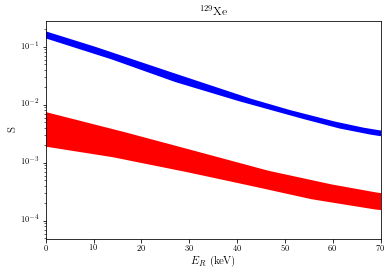

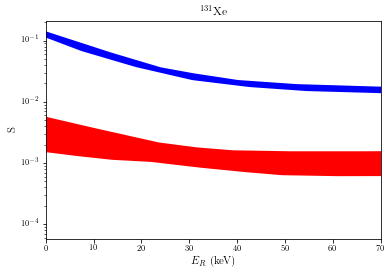

In [9]:
for isotope in 129, 131:
    for coupling in 'pn':
        plt.fill_between(es, 
                         data[(isotope, coupling, 'down')],
                         data[(isotope, coupling, 'up')],
                         color = {'p': 'red', 'n': 'blue'}[coupling],
                         linewidth=0,
                         label={'n': 'Neutron', 'p': 'Proton'}[coupling],
                        )
    plt.title(r'${}^{%d}$Xe' % isotope)
    plt.xlim(0, 70)
    plt.xlabel('$E_R$ (keV)')
    plt.ylabel('S')
    plt.yscale('log')
    plt.show()

Looks like curve tracing artifacts (inasfar as they are visible, hard to judge since original curves also have a few weird features) are smaller than the theoretical uncertainty.

Compares well with Mendenez et al. from final figure (left) in https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon100:papers:run10sd:comparison (proton=dashed). That's a different study, so it's not strange there are discrepancies, but we surely got the units right.

# WIMP spectra

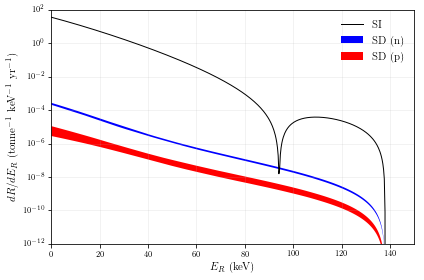

100%|██████████| 500/500 [00:40<00:00, 12.20it/s]


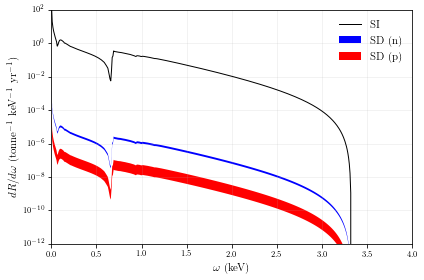

In [10]:
perkevtonyear = ((1000 * nu.kg)**-1 * nu.year**-1 * nu.keV**-1)

for rate_function, common, es, int_label in (
        [wimprates.rate_elastic, 
         dict(mw = 50 * nu.GeV/nu.c0**2, sigma_nucleon = 1e-45 * nu.cm**2), 
         np.linspace(1e-3, 150, 500),
         'NR'],
        [wimprates.rate_bremsstrahlung, 
         dict(mw = nu.GeV/nu.c0**2, sigma_nucleon = 1e-38 * nu.cm**2, progress_bar=True), 
         np.linspace(1e-3, 4, 500),
         'BS']
      ):
    
    plt.plot(
        es, 
        rate_function(es * nu.keV, interaction = 'SI', **common) / perkevtonyear, 
        label='SI', color='k', linewidth=1)

    for p, color in (('n', 'blue'), ('p', 'red')):
        plt.fill_between(
            es, 
            rate_function(es * nu.keV, interaction = 'SD_%s_down' % p, **common) / perkevtonyear, 
            rate_function(es * nu.keV, interaction = 'SD_%s_up' % p, **common) / perkevtonyear, 
            label='SD (%s)' % p, color=color, #alpha=dict(NR=1, BS=0)[int_label], 
            linewidth=0)
    
    e_symbol = dict(BS="\omega", NR="E_R")[int_label]
    plt.xlabel('$%s$ (keV)' % e_symbol)
    plt.ylabel("$dR/d%s$ (\si{{tonne}^{-1} {keV}^{-1} {yr}^{-1}})" % e_symbol)
    plt.xlim(0, es.max())
    plt.legend(loc='upper right', frameon=False)
    plt.yscale('log')
    plt.grid(alpha=0.2, linestyle='-')
    plt.tight_layout()
    plt.ylim(1e-12, 1e2)
    plt.savefig('wimp_spectrum_%s.pdf' % int_label)
    plt.show()
    